# DYNR1cv - Q-learning.

Prepared by: *Aleksej Gaj* ([email](mailto:aleksejalex@gmail.com))



In [3]:
%%capture
%pip install gymnasium
%pip install pygame

In [1]:
# imports:
import random
import numpy as np
#import gym  # old package, not maintained anymore
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display

## Q Learning

### Setup - "the lake has frozen"...

Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over 
the frozen lake. 

The player may not always move in the intended direction due to the slippery nature of the 
frozen lake.

[official documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

[unoficial tutorial](https://aleksandarhaber.com/installation-and-getting-started-with-openai-gym-and-frozen-lake-environment-reinforcement-learning-tutorial/)



### Formalization:

**Actions**:

| Action  | Description |
|---------|-------------|
| `0`       | Move Left   |
| `1`       | Move Down   |
| `2`       | Move Right  |
| `3`       | Move Up     |

**States**:
`nrows`x`ncols` grid, player’s current position = `current_row * nrows + current_col` (where both the row and col start at 0).

**Starting state**: 
 - always state `[0]` (ie. location [0, 0])

**Rewards**:

| Reward  | Description                       |
|---------|-----------------------------------|
| 0       | Frozen surface (Safe)             |
| 1       | Goal (Reach the goal)             |
| 0       | Hole (Fall into a hole)           |

**Terminal state(s)**:
 - goal (`G`) ... "win"
 - any hole (`H`) ... "lose"

**Is slippery?**
 - agent can the the action with p=1/3 and the "orthogonal" actions also with  p = 1/3 each

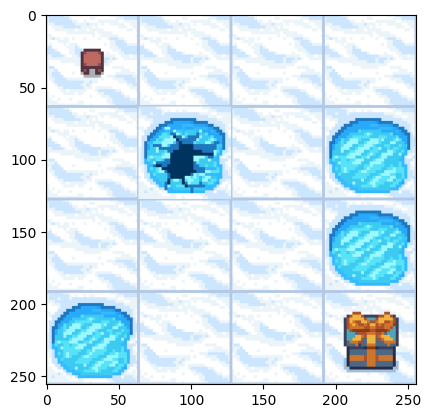

In [2]:
env = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array", is_slippery=True)

state=env.reset()[0]
done=False

while not done:
    action=env.action_space.sample()
    new_state, reward, done, info, x = env.step(action)
    img=plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Define your custom map:

```
F = firm ice
H = hole in the ice
G = goal
S = starting location
```

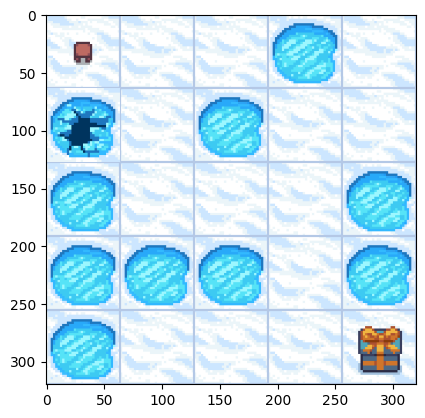

In [3]:
custom_map = [
    'SFFHF',
    'HFHFF',
    'HFFFH',
    'HHHFH',
    'HFFFG'
]

env = gym.make("FrozenLake-v1", desc=custom_map, render_mode="rgb_array", is_slippery=False)

state=env.reset()[0]
done=False

while not done:
    action=env.action_space.sample()
    new_state, reward, done, info, x = env.step(action)
    img=plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

Now we have working environment to test and visualize the algorithm.

### How Q-learning Works

1. **Initialization**: Start with a Q-table where all Q-values are set to zero.
2. **Exploration**: As you play the game, you explore different actions and update the Q-values based on the rewards received.
3. **Update Rule**: After taking an action, you update the Q-value using the formula:

   $$Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_a Q(s', a) - Q(s, a) \right)$$

   where:
   - $s$ is the current state,
   - $a$ is the action taken,
   - $r$ is the reward received,
   - $s'$ is the new state,
   - $\alpha$ is the learning rate,
   - $\gamma$ is the discount factor.

Over time, the Q-learning algorithm helps you learn the best actions to take in each state to successfully navigate the FrozenLake and reach the goal while avoiding holes.

### Q -learning - the code

In [4]:
env = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array", is_slippery=True)

In [5]:
n_states = env.observation_space.n
n_actions = env.action_space.n

In [6]:
print(f" num of states:{n_states}\n num of actions:{n_actions}")

 num of states:16
 num of actions:4


In [7]:
Q = np.zeros([n_states,n_actions])
Q.shape

(16, 4)

In [8]:
Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Constant vars:

In [9]:
episodes = 20000
alpha = 0.1  # learning rate
gamma = 0.99
G = 0   # G is sum of rewards
epsilon = 1.0  # Prob(take random action) 
min_epsilon = 0.01
max_epsilon = 1
decay_rate = 0.001

$\epsilon = \left( \epsilon_{max} - \epsilon_{min}\right) e^{-decayrate \: \cdot \: episode}$

In [10]:
print("Epsilon not in [0,1] !") if epsilon > 1 or epsilon < 0 else print('')
print("aplha not in [0,1] !") if alpha > 1 or alpha < 0 else print('')

In [11]:
reward_100 = 0
rewards_100 = []
epsilons = []

Training loop:

In [12]:
for episode in range(1, episodes+1):
    state = env.reset()[0] 
    done = False
    G = 0  # total reward of the episode
    while not done:
        if random.random() < epsilon:
            #random seed is less than epsilon, take random action
            action = env.action_space.sample()
        else: 
            #take optimal action
            action = np.argmax(Q[state])

        new_state, reward, done, _, _ = env.step(action)
        Q[state, action] += alpha*(reward + gamma*np.max(Q[new_state]) - Q[state,action])
        G = G + reward
        state = new_state
    reward_100 = reward_100 + G

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    epsilons.append(epsilon)

    if episode%100 == 0:
        print(f"Episode {episode}/{episodes}, mean reward: {reward_100 / 100}.")
        rewards_100.append(reward_100)
        reward_100 = 0

Episode 100/20000, mean reward: 0.02.
Episode 200/20000, mean reward: 0.02.
Episode 300/20000, mean reward: 0.01.
Episode 400/20000, mean reward: 0.05.
Episode 500/20000, mean reward: 0.01.
Episode 600/20000, mean reward: 0.04.
Episode 700/20000, mean reward: 0.08.
Episode 800/20000, mean reward: 0.05.
Episode 900/20000, mean reward: 0.06.
Episode 1000/20000, mean reward: 0.04.
Episode 1100/20000, mean reward: 0.05.
Episode 1200/20000, mean reward: 0.16.
Episode 1300/20000, mean reward: 0.2.
Episode 1400/20000, mean reward: 0.17.
Episode 1500/20000, mean reward: 0.2.
Episode 1600/20000, mean reward: 0.24.
Episode 1700/20000, mean reward: 0.24.
Episode 1800/20000, mean reward: 0.32.
Episode 1900/20000, mean reward: 0.29.
Episode 2000/20000, mean reward: 0.31.
Episode 2100/20000, mean reward: 0.31.
Episode 2200/20000, mean reward: 0.39.
Episode 2300/20000, mean reward: 0.33.
Episode 2400/20000, mean reward: 0.37.
Episode 2500/20000, mean reward: 0.39.
Episode 2600/20000, mean reward: 0.4

How rewards look like?

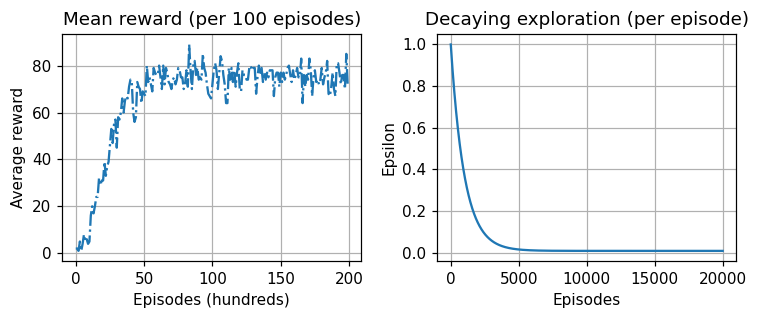

In [13]:
plt.figure(figsize=(7,3), dpi=110)
plt.subplot(1,2,1)
plt.plot(rewards_100, '-.')
plt.title("Mean reward (per 100 episodes)")
plt.xlabel("Episodes (hundreds)")
plt.ylabel("Average reward")
plt.grid()
plt.subplot(1,2,2)
plt.plot(epsilons, '-')
plt.title("Decaying exploration (per episode)")
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.grid()
plt.tight_layout()
plt.show()

How Q-table looks now, after training?

In [14]:
Q

array([[0.5432224 , 0.49697961, 0.49012204, 0.48912207],
       [0.34093782, 0.37715928, 0.26634045, 0.48597865],
       [0.4086516 , 0.4125838 , 0.42808187, 0.4516583 ],
       [0.25120156, 0.26811565, 0.36704253, 0.4393579 ],
       [0.57870348, 0.39811913, 0.37528233, 0.36498982],
       [0.        , 0.        , 0.        , 0.        ],
       [0.19660072, 0.18078516, 0.33756546, 0.13304808],
       [0.        , 0.        , 0.        , 0.        ],
       [0.42183471, 0.4884102 , 0.28456877, 0.60523005],
       [0.44214755, 0.6509421 , 0.49804919, 0.3961715 ],
       [0.57886372, 0.39558692, 0.36199128, 0.35586266],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.45303642, 0.42769084, 0.80053524, 0.52289456],
       [0.73900225, 0.89336241, 0.75865461, 0.74407098],
       [0.        , 0.        , 0.        , 0.        ]])

### Simulation

In [15]:
state=env.reset()[0]
done=False

In [16]:
rnd_act = 0
num_of_steps = 0

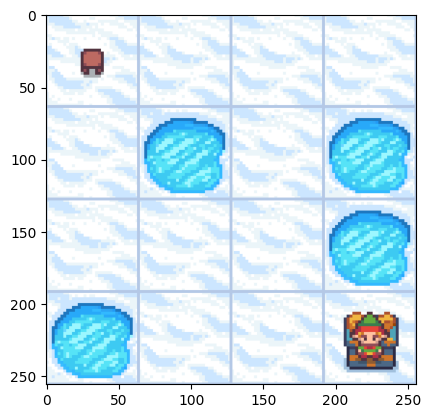

In [17]:
while not done:
    action = np.argmax(Q[state])
    new_state, reward, done, _, _ = env.step(action)

    img = plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state=new_state
    num_of_steps = num_of_steps + 1

In [46]:
print(f"Elf made {num_of_steps} steps in total.")

Elf made 17 steps in total.
